In [2]:
#load libraries
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [3]:
#connect to personal google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load data

In [4]:
data = pd.read_csv("/content/drive/MyDrive/UTRECHT UNIVERISTY/THESIS/DATA/HAIQI_DATA/df_iob_tags_final44.csv", encoding="latin1").fillna(method="ffill")
data.tail(10)

,ID,question,token,pos,tag
4086,317,What is density of greens for each PC4 area in...,density,NOUN,B-PROPIR
4087,317,What is density of greens for each PC4 area in...,of,ADP,O
4088,317,What is density of greens for each PC4 area in...,greens,NOUN,B-FLDN
4089,317,What is density of greens for each PC4 area in...,for,ADP,O
4090,317,What is density of greens for each PC4 area in...,each,DET,O
4091,317,What is density of greens for each PC4 area in...,PC4,PROPN,B-OBJ
4092,317,What is density of greens for each PC4 area in...,area,NOUN,I-OBJ
4093,317,What is density of greens for each PC4 area in...,in,ADP,O
4094,317,What is density of greens for each PC4 area in...,PlaceName0,PROPN,O
4095,317,What is density of greens for each PC4 area in...,\n,SPACE,O


In [5]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["token"].values.tolist(),
                                                           s["pos"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("question").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Question: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
getter = SentenceGetter(data)

In [7]:
#sentences in the dataset with their correpsonding tokens-words
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['From', 'where', 'are', 'wind', 'farms', 'visible', 'in', 'PlaceName0', '\n']

In [10]:
#The sentences are annotated with the IOB-schema and the labels look like this.
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'B-OBJ', 'I-OBJ', 'O', 'O', 'O', 'O']


In [ ]:
tag_values = list(set(data["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

#Apply Bert

###Prepare the sentences and labels

In [ ]:
!pip install transformers seqeval[gpu]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.8 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 6.6 MB 52.1 MB/s 
     |████████████████████████████████| 596 kB 74.1 MB/s 
     |████████████████████████████████| 101 kB 12.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=9180c9b0d38bf9237550a94a5c4b8034849ea3ac859bbc7c74ca700dcd318b6d
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.11.0+cu113'

In [ ]:
#define sequence length to 128 tokens and use a batch size of 2
MAX_LEN =128
bs = 2
# trbs = 4
# vabs = 2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
# load the pretrained tokenizer 'bert-base-cased' --> cased because it is well-suited for our sentences
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# tokenize all sentences
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
#cut and pad the token and label sequences to our desired length
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
#create masks to ignore the padded elements in the sequences (similarly to the masking in keras).
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
#split the dataset to train and test set
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Given that we are operating in pytorch, we should convert the datasets to torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
#define the dataloaders--> shuffle the data at training time with the RandomSampler and at test time pass them sequentially with the SequentialSampler
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [ ]:
print(train_dataloader)

###Setup the BERT model for finetuning

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.20.1'

In [ ]:
#load the pretrained bert-base-cased model and provide the number of possible labels.
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
#pass model parameters to the GPU
model.cuda();

In [ ]:
# Before starting the fine-tuning process, setup the optimizer and add the parameters it should update
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5,
    eps= 1e-8
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4            
max_grad_norm = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create a learning rate scheduler to linearly reduce the learning rate throughout the epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

###Grid Search - Hyperparameter tuning

OPTUNA

In [ ]:
#@title
# from transformers import EvalPrediction
# import numpy as np

# def compute_metrics(p: EvalPrediction):
#     preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
#     preds = np.argmax(preds, axis=1)
#     return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [ ]:
#@title
# from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# training_args = TrainingArguments(
#     output_dir='/content/results',    # output directory
#     #evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
#     evaluation_strategy="steps",      # Evaluation is done (and logged) every eval_steps.
#     eval_steps=1000,                  # Number of update steps between two evaluations 
#     per_device_eval_batch_size=64,    # batch size for evaluation
#     save_total_limit=1,               # limit the total amount of checkpoints. Deletes the older checkpoints.
# )

# def model_init():
#     model = BertForSequenceClassification.from_pretrained('bert-base-cased',return_dict=True)
#     for param in model.base_model.parameters():
#         param.requires_grad = False
#     return model

# trainer = Trainer(
#     args=training_args,                  # training arguments, defined above
#     train_dataset=train_dataset,         # training dataset
#     eval_dataset=val_dataset,            # evaluation dataset
#     compute_metrics=compute_metrics,     # metrics to be computed
#     model_init=model_init                # Instantiate model before training starts
# )

# def my_hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
#         "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 20),
#         "seed": trial.suggest_int("seed", 1, 40),
#         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32, 64]),
#     }
# def my_objective(metrics):
#     return metrics["eval_loss"]

# best_run = trainer.hyperparameter_search(direction="minimize", hp_space=my_hp_space, compute_objective=my_objective, n_trials=100)

# with open("/content/drive/My Drive/cord19/best_run.json", "w+") as f:
#   f.write(json.dumps(best_run.hyperparameters))

 Hugging Face tuner

In [ ]:
#@title
# from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
#                           Trainer, TrainingArguments)
                          

In [ ]:
#@title
# def model_init():
#     return AutoModelForSequenceClassification.from_pretrained(
#         'distilbert-base-uncased', return_dict=True)

In [ ]:
#@title
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = predictions.argmax(axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

In [ ]:
#@title
# training_args = TrainingArguments(
#     "test", evaluation_strategy="steps", eval_steps=500, disable_tqdm=True)
# trainer = Trainer(
#     args=training_args,
#     tokenizer=tokenizer,
#     train_dataset=train_dataloader,
#     eval_dataset=valid_dataloader,
#     model_init=model_init,
#     compute_metrics=compute_metrics,
# )


In [ ]:
#@title
# best_trial = trainer.hyperparameter_search(
#     direction="maximize",
#     backend="ray",
#     # Choose among many libraries:
#     # https://docs.ray.io/en/latest/tune/api_docs/suggestion.html
#     search_alg=HyperOptSearch(metric="objective", mode="max"),
#     # Choose among schedulers:
#     # https://docs.ray.io/en/latest/tune/api_docs/schedulers.html
#     scheduler=ASHAScheduler(metric="objective", mode="max"))

In [ ]:
#@title
# Default objective is the sum of all metrics
# when metrics are provided, so we have to maximize it.
# trainer.hyperparameter_search(
#     direction="maximize", 
#     backend="ray", 
#     n_trials=10 # number of trials 
#     )

####Fit BERT for named entity recognition

In [ ]:
#load evaluation metrics
from seqeval.metrics import f1_score, accuracy_score, classification_report, recall_score, precision_score

####Fine-tune the BERT model

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
correct= 0

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print(classification_report([pred_tags], [valid_tags]))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Average train loss: 0.2686239613441529


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:12<00:37, 12.62s/it]

Validation loss: 0.09855494124349207
Validation Accuracy: 0.7919847328244275
              precision    recall  f1-score   support

        CNAC       0.00      0.00      0.00         0
        CVAL       0.00      0.00      0.00         0
         EVE       0.00      0.00      0.00         0
        FLDI       0.00      0.00      0.00         0
        FLDN       0.00      0.00      0.00         0
        FLDR       0.50      0.60      0.55         5
       NETQR       0.00      0.00      0.00         0
         OBJ       0.62      0.25      0.36        84
       OBJQB       0.00      0.00      0.00         0
       OBJQR       0.00      0.00      0.00         0
      PROPIR       0.00      0.00      0.00         0

   micro avg       0.33      0.27      0.30        89
   macro avg       0.10      0.08      0.08        89
weighted avg       0.61      0.27      0.37        89

Average train loss: 0.07206638446859234


Epoch:  50%|█████     | 2/4 [00:25<00:25, 12.66s/it]

Validation loss: 0.042762968892930076
Validation Accuracy: 0.9217557251908397
              precision    recall  f1-score   support

        CNAC       0.75      0.75      0.75         4
        CVAL       1.00      0.50      0.67         6
         EVE       0.67      0.46      0.55        13
        FLDI       0.00      0.00      0.00         0
        FLDN       0.33      0.75      0.46         4
        FLDR       0.83      0.71      0.77         7
       NETQR       1.00      1.00      1.00         1
         OBJ       0.82      0.70      0.76        40
       OBJQB       0.00      0.00      0.00         0
       OBJQR       0.00      0.00      0.00         0
      PROPIR       0.50      0.40      0.44         5

   micro avg       0.70      0.64      0.67        80
   macro avg       0.54      0.48      0.49        80
weighted avg       0.77      0.64      0.69        80

Average train loss: 0.03576758174694605


Epoch:  75%|███████▌  | 3/4 [00:37<00:12, 12.54s/it]

Validation loss: 0.03418949210754363
Validation Accuracy: 0.9446564885496184
              precision    recall  f1-score   support

        CNAC       0.75      0.75      0.75         4
        CVAL       1.00      1.00      1.00         3
         EVE       0.78      0.70      0.74        10
        FLDI       0.00      0.00      0.00         0
        FLDN       0.44      1.00      0.62         4
        FLDR       1.00      1.00      1.00         6
       NETQR       1.00      1.00      1.00         1
         OBJ       0.74      0.69      0.71        36
       OBJQB       1.00      1.00      1.00         1
       OBJQR       0.00      0.00      0.00         2
      PROPIR       0.75      0.50      0.60         6

   micro avg       0.73      0.73      0.73        73
   macro avg       0.68      0.69      0.67        73
weighted avg       0.75      0.73      0.73        73

Average train loss: 0.023191131289944156


Epoch: 100%|██████████| 4/4 [00:51<00:00, 12.86s/it]

Validation loss: 0.028785674650862347
Validation Accuracy: 0.9522900763358778
              precision    recall  f1-score   support

        CNAC       0.75      0.75      0.75         4
        CVAL       1.00      1.00      1.00         3
         EVE       0.89      0.89      0.89         9
        FLDI       0.00      0.00      0.00         0
        FLDN       0.67      0.86      0.75         7
        FLDR       1.00      0.86      0.92         7
       NETQR       1.00      1.00      1.00         1
         OBJ       0.76      0.70      0.73        37
       OBJQB       1.00      1.00      1.00         1
       OBJQR       0.00      0.00      0.00         2
      PROPIR       0.75      0.75      0.75         4

   micro avg       0.78      0.76      0.77        75
   macro avg       0.71      0.71      0.71        75
weighted avg       0.79      0.76      0.77        75



###BERT Evaluation Metrics

In [ ]:
# number of total entities per tag in the validation/test set
from collections import Counter
c = Counter(valid_tags)

print( c.items() )

dict_items([('O', 397), ('B-FLDN', 7), ('I-FLDN', 9), ('B-OBJ', 34), ('B-EVE', 9), ('B-PROPIR', 4), ('I-OBJ', 20), ('B-OBJQR', 1), ('I-OBJQR', 2), ('B-CVAL', 3), ('I-CVAL', 9), ('I-EVE', 6), ('B-FLDR', 6), ('I-FLDR', 3), ('B-OBJQB', 1), ('I-OBJQB', 1), ('B-CNAC', 4), ('B-FLDI', 1), ('I-CNAC', 1), ('B-NETQR', 1), ('I-NETQR', 1), ('I-PROPIR', 4)])


In [ ]:
print("F1-score is : {:.1%}".format(f1_score([pred_tags], [valid_tags])))

F1-score is : 77.0%


In [ ]:
print("Recall is : {:.1%}".format(recall_score([pred_tags], [valid_tags])))

Recall is : 76.0%


In [ ]:
print("Precision is : {:.1%}".format(precision_score([pred_tags], [valid_tags])))

Precision is : 78.1%


### Plot training and validation loss of the model for each epoch

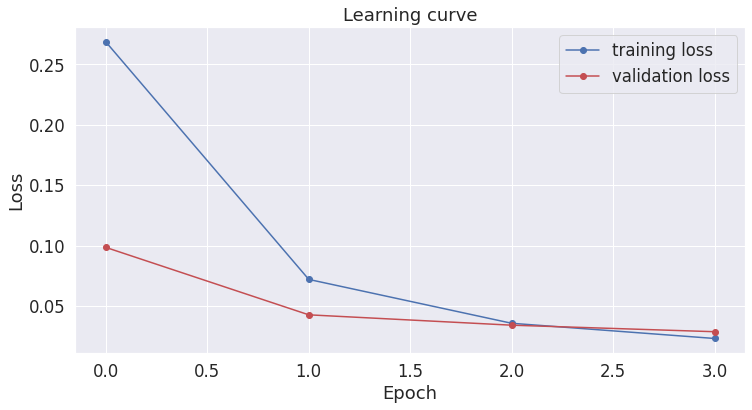

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Evaluate model's performance on new sentences from the additional geo-analytical question corpus

In [2]:
#test_sentence = "What are the two fire stations closest to each school in Utrecht"

In [3]:
# tokenized_sentence = tokenizer.encode(test_sentence)
# input_ids = torch.tensor([tokenized_sentence]).cuda()

In [4]:
# with torch.no_grad():
#     output = model(input_ids)
# label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [5]:
# # join bpe split tokens
# tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
# new_tokens, new_labels = [], []
# for token, label_idx in zip(tokens, label_indices[0]):
#     if token.startswith("##"):
#         new_tokens[-1] = new_tokens[-1] + token[2:]
#     else:
#         new_labels.append(tag_values[label_idx])
#         new_tokens.append(token)

In [1]:
# for token, label in zip(new_tokens, new_labels):
#     print("{}\t{}".format(label, token))

#-----------------------------------------------------------------------------------